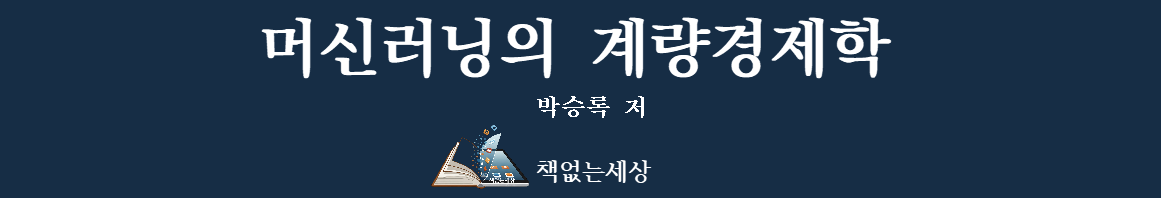

# Part 7: 시계열 분석

## Chapter 2: ARIMA 모형

In [1]:
# 작업공간(working directory)지정  
import os  
os.chdir("E:/JupyterWDirectory/MyStock")
os.getcwd()

'E:\\JupyterWDirectory\\MyStock'

In [2]:
exec(open('E:/JupyterWDirectory/MyStock/Functions/Traditional_Econometrics_Lib.py').read())

In [3]:
"""
# #####################################################################
# 위의 함수는 아래 다양한 라이브러리와 함수를 한 문장으로 불러오는 방법
# #####################################################################

# 분석에 사용될 라이브러리(Libraries for the Analysis) 불러오기
# Libraries for the Analysis of Traditional Econometrics.py
# 불러오는 방법:  "exec(open('Functions/Traditional_Econometrics_Lib.py').read())"
# #####################################################################

# 만약 특정 라이브러리가 설치되지 않았다는 에러 메시지가 나타날 때는 
# 해당 라이브러리를 설치하여야 함
# 아래 라이브러리를 하나 하나 실행하면서 어떤 라이브러리가 설치되지 않았는지 확인하여도 됨
# #####################################################################
import os
import numpy as np                                       # Numerical calculations
import pandas as pd                                      # Data handling
import math as someAlias
import matplotlib.dates as mdates                        # Turn dates into numbers
import matplotlib.pyplot as plt                          # Lower-level graphics
import patsy as pt
import seaborn as sns
import stargazer.stargazer as sg
import statsmodels.api as sm
import statsmodels.formula.api as smf                    # Econometrics
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.outliers_influence as smo
import linearmodels as lm                                # Panel model, Simultaneous Eq. Model
import scipy.stats as stats                              # Statistics
import random

from scipy.optimize import Bounds
from scipy.optimize import curve_fit                    # Nonlinear regression
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.graphics import tsaplots               # Time series
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller          # ADF test
from statsmodels.tsa.stattools import coint             # Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model

import wooldridge as woo
from imfpy.retrievals import dots
import wbdata
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")
"""\

SyntaxError: incomplete input (3511643513.py, line 56)

## 2. ARIMA 모형의 차수 결정

In [4]:
# 한국의 거시경제 통계자료 불러오기
data = pd.read_csv('E:/JupyterWDirectory/Udemy Time Series/Data/Korea_GDP.csv',index_col='Time', parse_dates=True)
new_index = pd.date_range(start='1961-03-31', periods=len(data), freq='Q')
data.index = pd.to_datetime(new_index)
data.index

DatetimeIndex(['1961-03-31', '1961-06-30', '1961-09-30', '1961-12-31',
               '1962-03-31', '1962-06-30', '1962-09-30', '1962-12-31',
               '1963-03-31', '1963-06-30',
               ...
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30',
               '2022-09-30', '2022-12-31', '2023-03-31', '2023-06-30',
               '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', length=252, freq='Q-DEC')

In [5]:
# GDP의 ACF(Autocorrelation Function)
acf(data['gdp'])

array([1.        , 0.98534276, 0.97614955, 0.96450236, 0.9584663 ,
       0.94375715, 0.9341805 , 0.92214724, 0.9155298 , 0.90059785,
       0.89104636, 0.87902214, 0.87222651, 0.85763243, 0.84818933,
       0.83686083, 0.82984012, 0.81451313, 0.80413416, 0.79149513,
       0.78391391, 0.76860532, 0.7579527 , 0.74511994, 0.7370648 ])

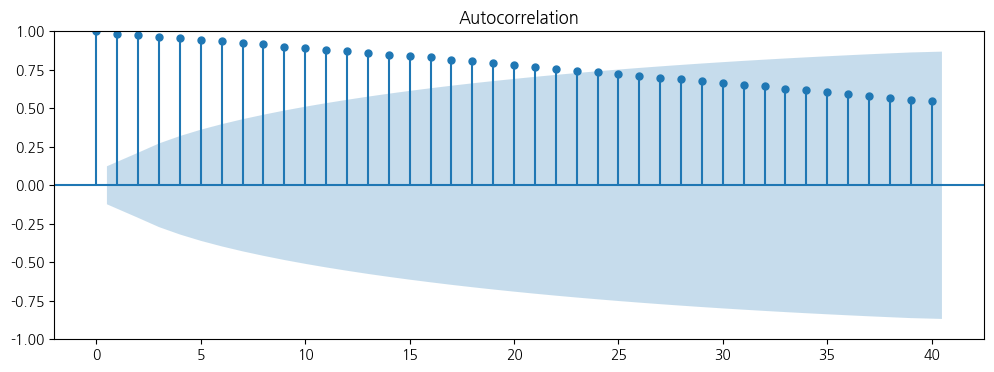

In [6]:
# ACF 그래프 그리기
fig, ax = plt.subplots(figsize=(12,4))
title = 'Autocorrelation'
plot_acf(data['gdp'],title=title,lags=40, ax=ax);

In [7]:
# GDP의 PACF(Partial Autocorrelation Function)
pacf(data['gdp'])

array([ 1.00000000e+00,  9.89268430e-01,  2.48581872e-01, -6.09734724e-02,
        2.33150947e-01, -3.37075085e-01,  9.42985444e-02,  3.73780848e-03,
        1.07734731e-01, -2.24427586e-01,  8.38923982e-02,  1.27230571e-02,
        6.17553334e-02, -1.48863038e-01,  5.25698231e-02,  5.31189618e-02,
       -6.84818623e-03, -1.77900352e-01,  2.88216880e-02,  4.04127036e-04,
        5.07866705e-02, -1.14452550e-01,  8.93759329e-03,  5.78778622e-03,
        2.49060728e-02])

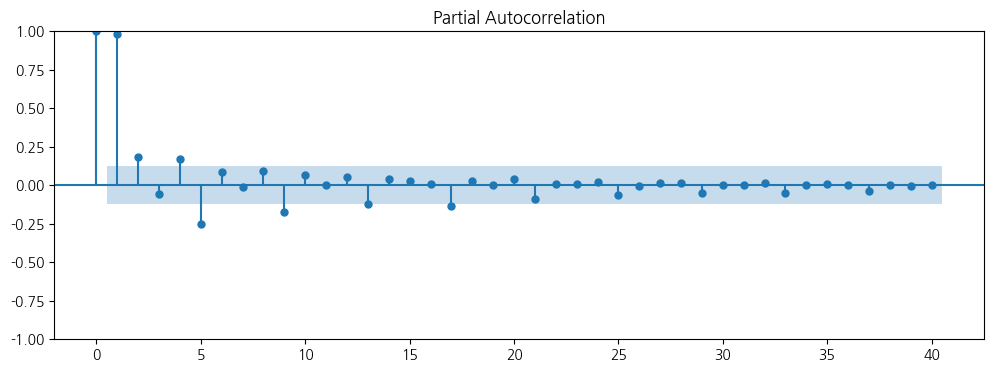

In [8]:
# PACF 그래프 그리기
fig, ax = plt.subplots(figsize=(12,4))
title='Partial Autocorrelation'
plot_pacf(data['gdp'],title=title,lags=40, ax=ax);

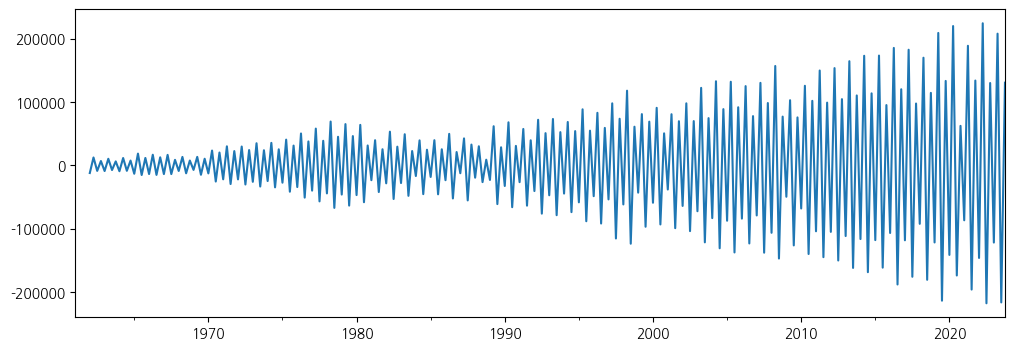

In [9]:
data['D_gdp'] = diff(data[['gdp']], k_diff=4)
data['D_gdp'].plot(figsize=(12,4));

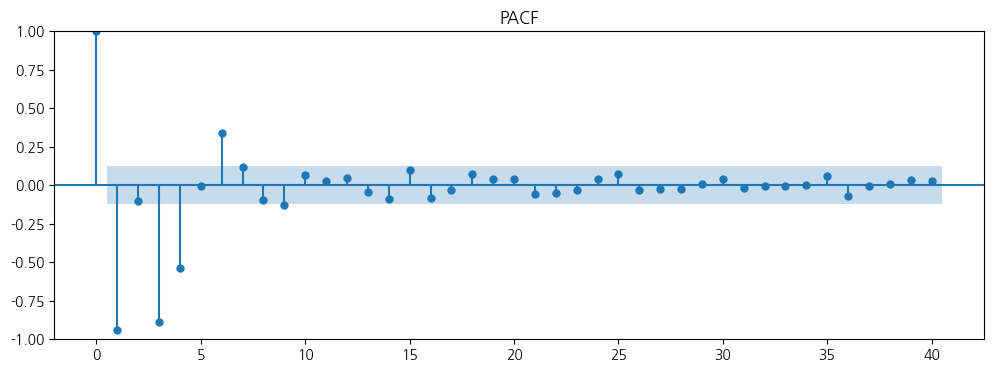

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(data['D_gdp'].dropna(),title='PACF',lags=40,ax=ax); 

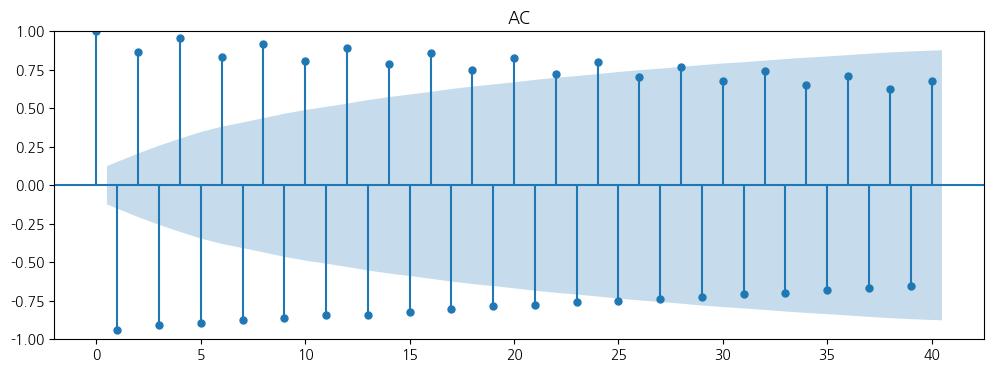

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(data['D_gdp'].dropna(),title='AC',lags=40, ax=ax);

## 3. ARMA 모형의 차수 자동 선택

In [12]:
arma_order_select_ic(data['gdp'])

{'bic':              0            1            2
 0  7914.718662  6611.827327  6558.179855
 1  5534.273054  5448.875383  5576.037630
 2  5427.429101  5318.945998  5271.432239
 3  5432.894640  5329.287336  5326.451483
 4  5319.236133  5150.112479  5133.155559,
 'bic_min_order': (4, 2)}

## 5. ARIMA 모형을 이용한 예측

### 가. 예측력 평가

154905512.25624317 12446.104300392279


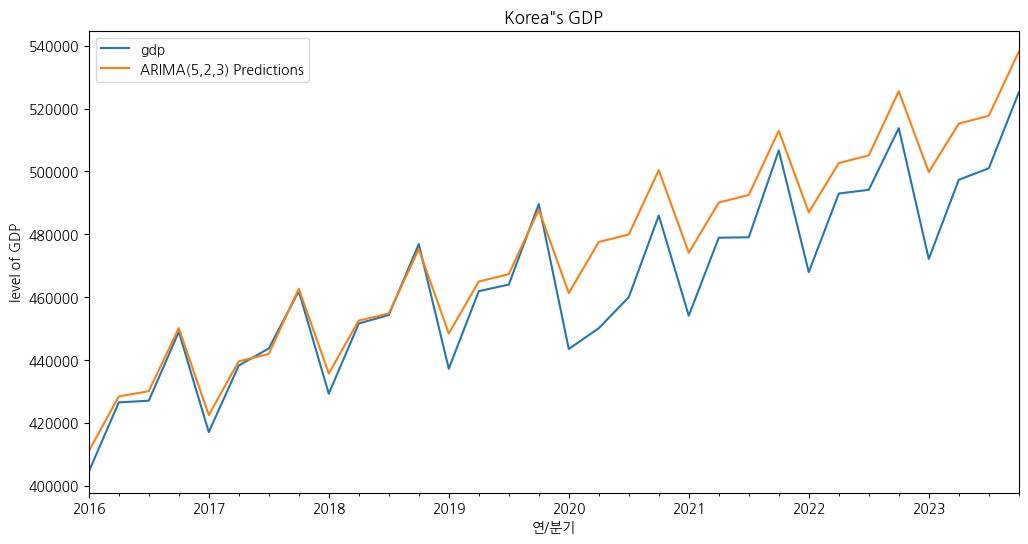

In [14]:
from statsmodels.tsa.arima.model import ARIMA 
train = data.loc[:'2015-12-31']
test = data.loc['2016-03-31':]

model = ARIMA(train['gdp'],order=(5,2,3))
results = model.fit()
results.summary()

start='2016-3-31'
end='2023-12-31'
predictions = results.predict(start=start, end=end).rename('ARIMA(5,2,3) Predictions')
predictions

 # 사후예측과 실적치 
title = 'Korea"s GDP'
ylabel='level of GDP'
xlabel='연/분기'

ax = test['gdp'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

mse = mean_squared_error(test['gdp'], predictions)
rmse =  np.sqrt(mse)
print(mse, rmse)

[Text(0.5, 0, '연/분기'), Text(0, 0.5, 'Level')]

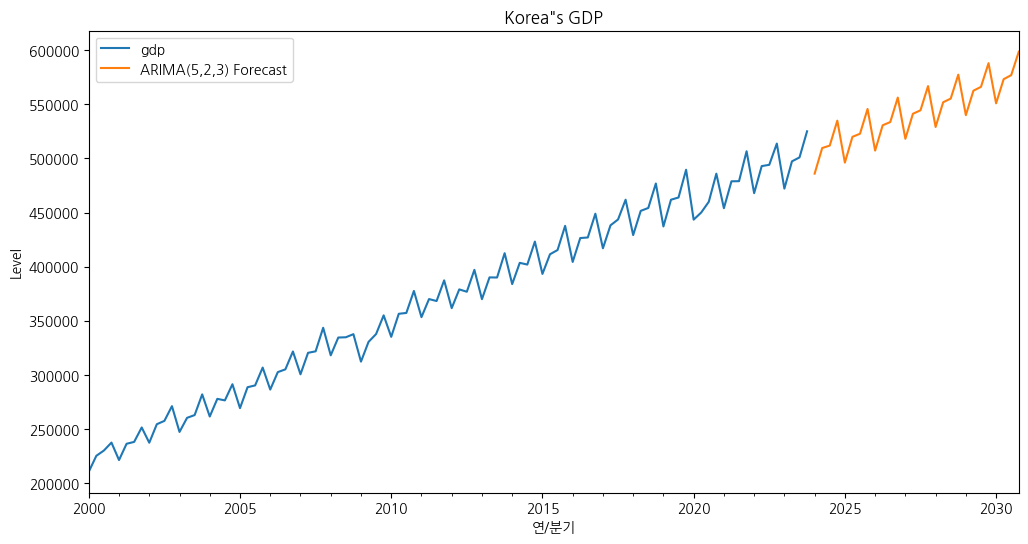

In [15]:
model = ARIMA(data['gdp'],order=(5,2,3))
results = model.fit()
fcast = results.predict('2024-3-31','2030-12-31',typ='levels').rename('ARIMA(5,2,3) Forecast')

# 사전예측 그리프
title = 'Korea"s GDP'
ylabel='Level'
xlabel='연/분기' 

ax = data['gdp'].loc['2000-03-31':].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(5, 2, 3)   Log Likelihood               -2384.143
Date:                Thu, 24 Jul 2025   AIC                           4786.286
Time:                        09:57:39   BIC                           4817.979
Sample:                    03-31-1961   HQIC                          4799.042
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0788      0.066     -1.202      0.229      -0.207       0.050
ar.L2         -0.5811      0.050    -11.540      0.000      -0.680      -0.482
ar.L3         -0.5749      0.049    -11.638      0.0

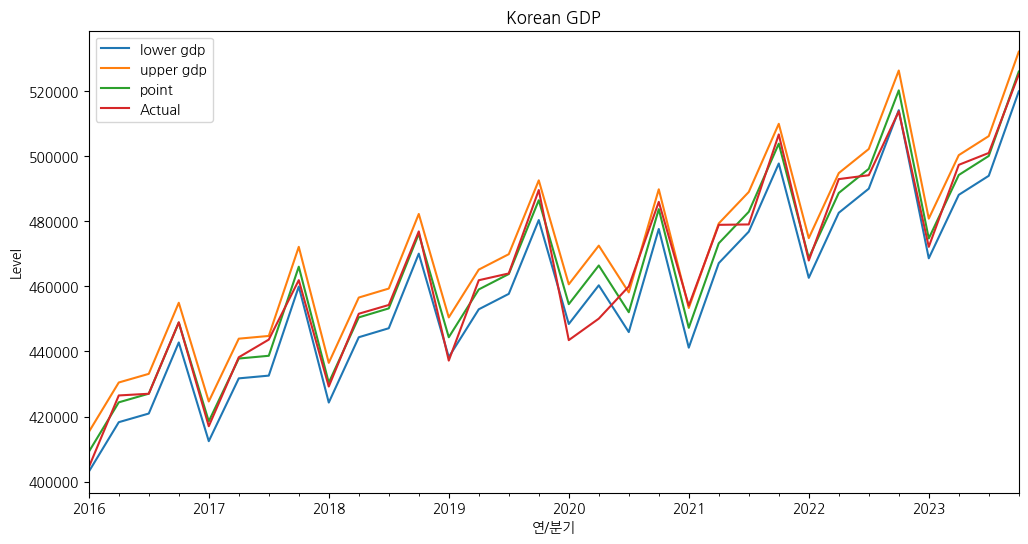

In [18]:
#!pip install pmdarima
from pmdarima import auto_arima

# 계절적 요인을 무시한 SARIMA(ARIMA) 
results = auto_arima(data['gdp'], seasonal=False, m=4)
print(results.summary())

# 계절적 요인을 고려한 SARIMA
results = auto_arima(data['gdp'], seasonal=True, m=4)
print(results.summary())

# 사후 예측(ex-post) 예측력 평가
# 데이터세트을 훈련데이터와 검증 데이터로 나누기
train = data.loc[:'2015-12-31']
test = data.loc['2016-03-31':]

# 모형 추정
model = SARIMAX(data['gdp'],order=(0,1,0),seasonal_order=(1, 1, [1, 2], 4))
results = model.fit()
results.summary()

# 사후예측 그래프 그리기
start='2016-3-31'
end='2023-12-31'
predictions = results.get_prediction(start=start, end=end)
pred_point = results.predict(start=start, end=end)
pred_ci = predictions.conf_int()
pred_ci['point'] =pred_point
pred_ci['Actual'] =data['gdp']
print(pred_ci)

# 사후예측 그래프 그리기
title = 'Korean GDP'
ylabel='Level'
xlabel='연/분기'
ax = pred_ci.plot(figsize=(12,6),legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel); 

# 예측력의 평가
mse = mean_squared_error(test['gdp'], pred_ci['point'])
rmse =  np.sqrt(mse)
print(mse, rmse)

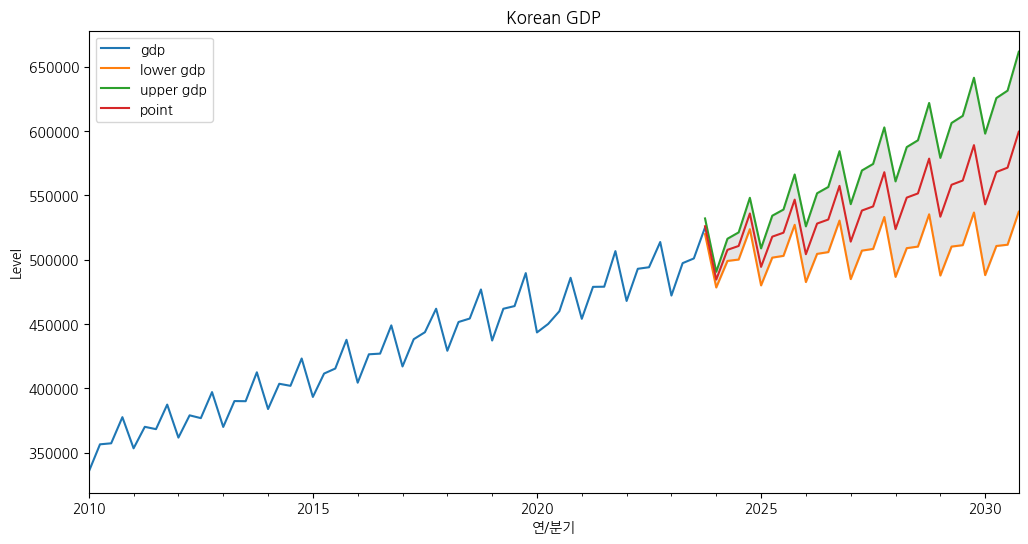

In [19]:
# 사전(ex-ante) 예측
model = SARIMAX(data['gdp'],order=(0,1,0),seasonal_order=(1,1,[1,2],4))
results = model.fit()
predictions = results.get_prediction('2023-12-31','2030-12-31',typ='levels')
pred_point = results.predict('2023-12-31','2030-12-31')
pred_ci = predictions.conf_int()
pred_ci['point'] =pred_point
pred_ci

# 샘플범위 밖 예측 및 예측 오차의 그래프
title = 'Korean GDP'
ylabel='Level'
xlabel='연/분기'

fig, ax = plt.subplots()
ax = data['gdp'].loc['2010-03-31':].plot(legend=True,figsize=(12,6),title=title)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='grey' , alpha=0.2)
pred_ci.plot(legend=True, ax=ax)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);
plt.show()